## Imports

In [1]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import math
import os

from scipy.stats import spearmanr, pearsonr
from scipy import nanmean, nanstd
from scipy.special import softmax
from scipy.spatial.distance import jensenshannon
import matplotlib
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.interpolate import interpn

plt.rcParams["figure.figsize"]=15,15
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

from random import sample
import pybedtools
from plotnine import *

## Addresses

In [2]:
ism_indir = '/oak/stanford/groups/akundaje/laks/illuminafiles/cardiomyogenesis/BPNET_deepshaps/motif_ism'
ism_scoredir = '/oak/stanford/groups/akundaje/projects/cardiogenesis/motif_ism'
ism_outdir = '/oak/stanford/groups/akundaje/projects/cardiogenesis/motif_ism'
peak_dir = '/oak/stanford/groups/akundaje/projects/cardiogenesis/peaks_renamed'

## Check Outdir

In [3]:
if not os.path.isdir(ism_outdir):
    os.mkdir(ism_outdir)

## Load Motif Table

In [3]:
motifs = pd.read_csv(ism_outdir + '/' + 'motif.hits.bed', sep='\t')

display(motifs.head())
print()
display(motifs.shape)

,chr,start,end,tf_name,tf_group,width,strand,score
0,chr1,827308,827317,TFAP4_23,23,10,+,8.642197
1,chr1,827330,827349,TP53_706,706,20,-,0.558635
2,chr1,827332,827342,ELK4_341,341,11,-,9.099155
3,chr1,827333,827342,ETS1_332,332,10,-,8.216554
4,chr1,827333,827343,GABPA_338,338,11,-,8.423750


(14950565, 8)

## Load ISM Scores

In [ ]:
fold = 0
chroms = ['chr' + str(x) for x in range(1, 23)] + ['chrX']

motif_dict = {x:[] for x in chroms}

for chrom in chroms:
    
    print(chrom)
    
    orig_dict = {'atrial': [], 'cfmature': [], 'cfwk8': [], 'epiicardium': [],
                 'myocardium': [], 'smcwk19': [], 'smcwk8': [], 'valvelate': [], 'ventricular': [],
                 'arteries': [], 'capillary': [], 'cfwk6': [], 'endocardium': [], 'lymphec': [],
                 'neuralcrest': [], 'pericytes': [], 'smcwk6': [], 'valveearly': [], 'veins': [], 'all': []}
    
    chr_motif_scores = motifs.loc[motifs['chr'] == chrom].copy()
    
    for cluster in orig_dict:
        
        print(cluster)
        
        orig_counts = np.load(ism_indir + '/' + cluster + '/fold' + str(fold) + '/' + chrom + '.orig_counts.npy')
        shuf_counts0 = np.load(ism_indir + '/' + cluster + '/fold' + str(fold) + '/' + chrom + '.shuf_counts.0.npy')
        shuf_counts1 = np.load(ism_indir + '/' + cluster + '/fold' + str(fold) + '/' + chrom + '.shuf_counts.1.npy')
        shuf_counts2 = np.load(ism_indir + '/' + cluster + '/fold' + str(fold) + '/' + chrom + '.shuf_counts.2.npy')
        shuf_counts_median = np.median(np.stack((shuf_counts0, shuf_counts1, shuf_counts2)), axis=0)
        logfc_counts = np.log2(np.sum(orig_counts, axis=1) / np.sum(shuf_counts_median, axis=1))

        chr_motif_scores[cluster + '_motif_logfc'] = logfc_counts
        
    motif_dict[chrom] = chr_motif_scores
    
    display(motif_dict[chrom].head())
    print()
    display(motif_dict[chrom].shape)

## Display Motif ISM Scores

In [ ]:
for chrom in chroms:
    print(chrom)
    display(motif_dict[chrom].head())
    print()
    display(motif_dict[chrom].shape)

## Concatenate Motif Score DFs

In [17]:
to_concat = [motif_dict[x] for x in motif_dict]
all_scores = pd.concat(to_concat)

display(all_scores.head())
print()
display(all_scores.shape)

,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827308,827317,TFAP4_23,23,10,+,8.642197,0.031981,0.001621,...,-0.016592,-0.031920,-0.086045,0.002661,0.022499,-0.022262,-0.018346,-0.008158,-0.032698,0.048562
1,chr1,827330,827349,TP53_706,706,20,-,0.558635,0.175540,0.050794,...,0.271743,0.073436,0.166649,0.025630,0.004884,0.062407,0.063134,0.070964,0.030418,0.074180
2,chr1,827332,827342,ELK4_341,341,11,-,9.099155,0.118709,0.106342,...,0.289297,0.074657,0.112512,0.051665,-0.003879,0.079872,0.042494,0.098870,0.066708,0.239036
3,chr1,827333,827342,ETS1_332,332,10,-,8.216554,0.121135,0.082777,...,0.285599,0.072843,0.100030,0.058699,0.001098,0.081662,0.041229,0.078143,0.061024,0.254197
4,chr1,827333,827343,GABPA_338,338,11,-,8.423750,0.172376,0.116309,...,0.335445,0.083054,0.160597,0.063036,0.016597,0.093625,0.051085,0.105485,0.051499,0.179919


(14950565, 28)

## Save / Load 5x Motif-ISM Scores

In [4]:
# all_scores.to_csv(ism_outdir + '/all_scores_5x.tsv', index=False, sep='\t')

all_scores = pd.read_csv(ism_scoredir + '/all_scores_5x.tsv', sep='\t')

display(all_scores.head())
print()
display(all_scores.shape)

,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827308,827317,TFAP4_23,23,10,+,8.642197,0.031981,0.001621,...,-0.016592,-0.031920,-0.086045,0.002661,0.022499,-0.022262,-0.018346,-0.008158,-0.032698,0.048562
1,chr1,827330,827349,TP53_706,706,20,-,0.558635,0.175540,0.050794,...,0.271743,0.073436,0.166649,0.025630,0.004884,0.062407,0.063134,0.070964,0.030418,0.074180
2,chr1,827332,827342,ELK4_341,341,11,-,9.099155,0.118709,0.106342,...,0.289297,0.074657,0.112512,0.051665,-0.003879,0.079872,0.042494,0.098870,0.066708,0.239036
3,chr1,827333,827342,ETS1_332,332,10,-,8.216554,0.121135,0.082777,...,0.285599,0.072843,0.100030,0.058699,0.001098,0.081662,0.041229,0.078143,0.061024,0.254197
4,chr1,827333,827343,GABPA_338,338,11,-,8.423750,0.172376,0.116309,...,0.335445,0.083054,0.160597,0.063036,0.016597,0.093625,0.051085,0.105485,0.051499,0.179919


(14950565, 28)

## Get Null ISM Scores


atrial


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 25 rows containing non-finite values.
/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


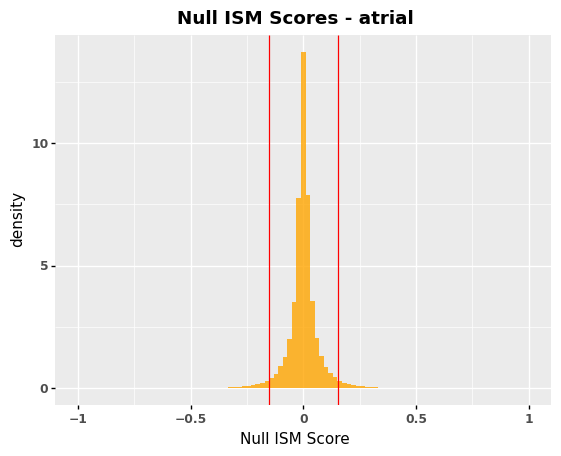

<ggplot: (8783318760500)>



cfmature


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 210 rows containing non-finite values.
/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


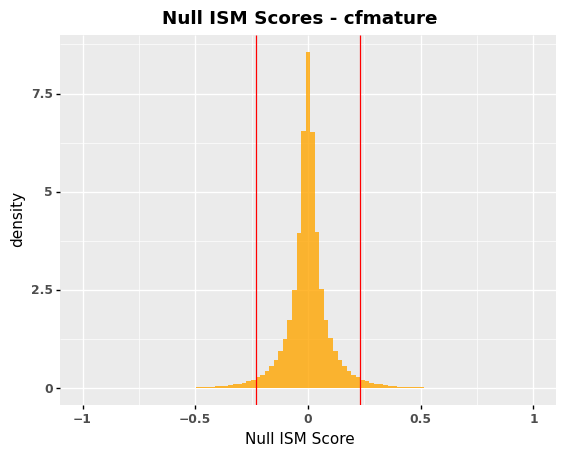

<ggplot: (8783322676158)>



cfwk8


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 395 rows containing non-finite values.
/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


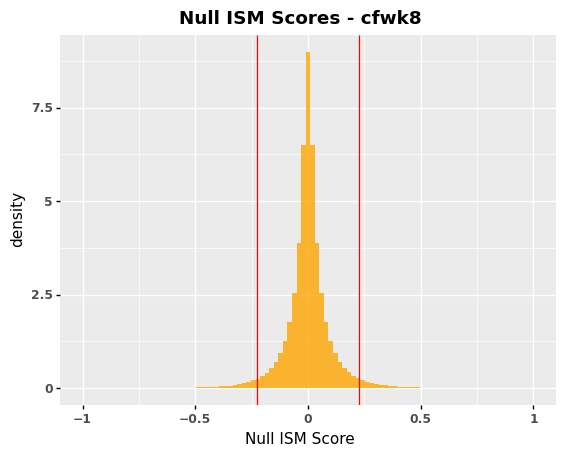

<ggplot: (8783322661876)>



epiicardium


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


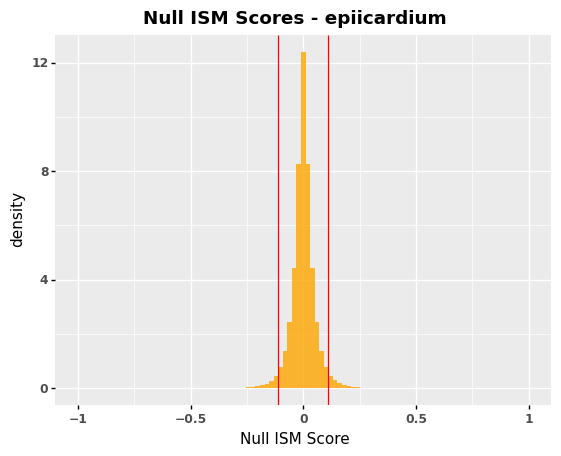

<ggplot: (8783322660359)>



myocardium


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 27 rows containing non-finite values.
/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


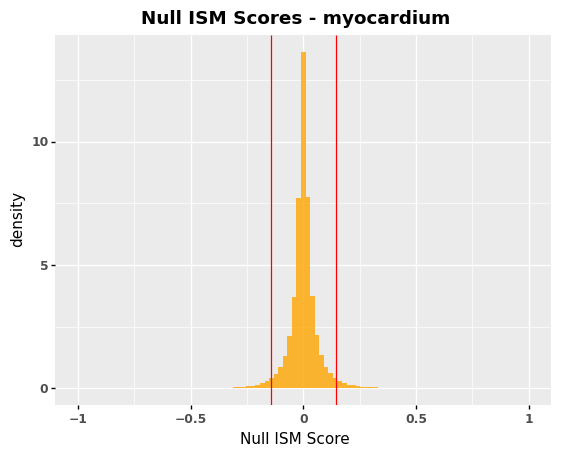

<ggplot: (8783322617357)>



smcwk19


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


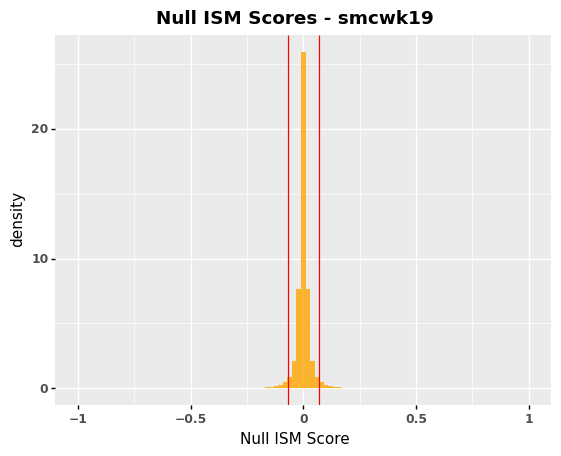

<ggplot: (8783322608186)>



smcwk8


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


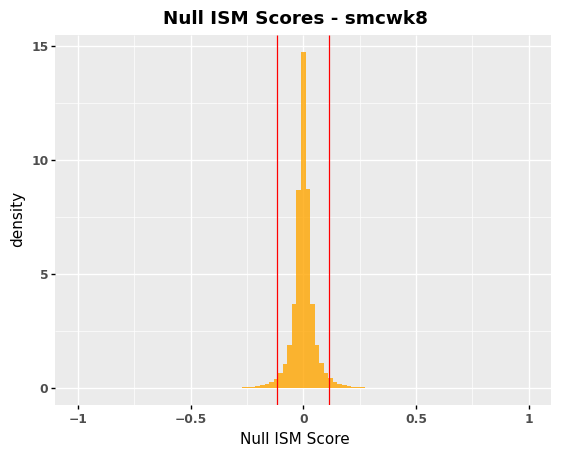

<ggplot: (8783322599587)>



valvelate


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


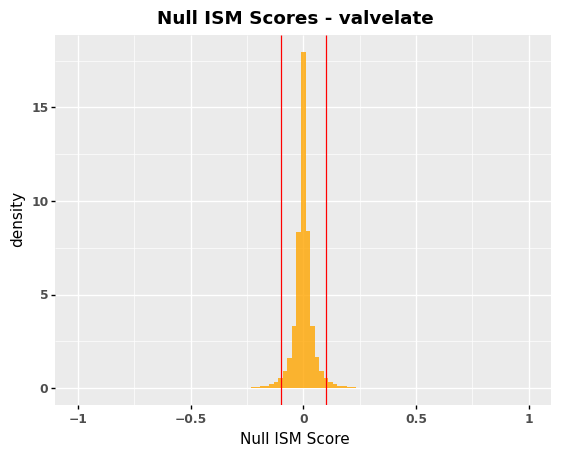

<ggplot: (8783322501825)>



ventricular


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 1608 rows containing non-finite values.
/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


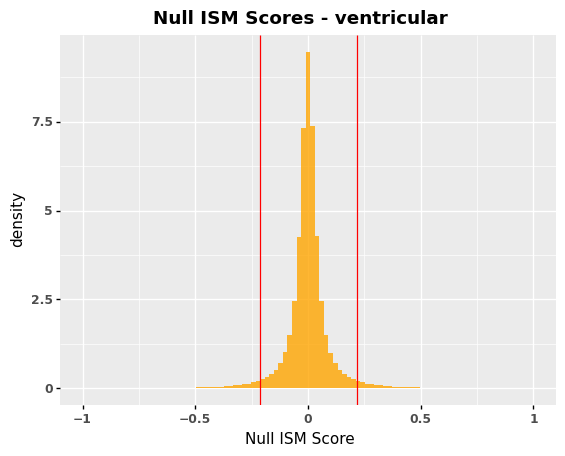

<ggplot: (8783322707188)>



arteries


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 3359 rows containing non-finite values.
/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


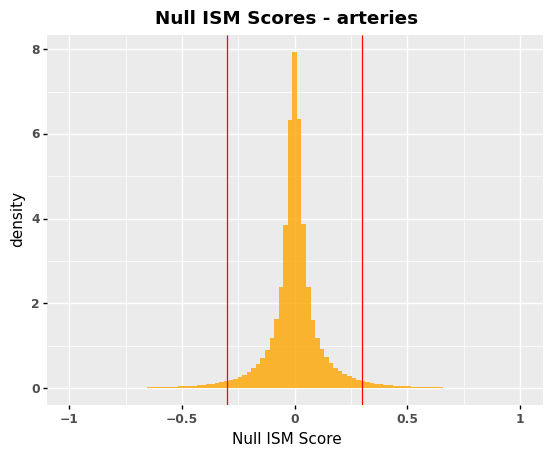

<ggplot: (8783321923741)>



capillary


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 457 rows containing non-finite values.
/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


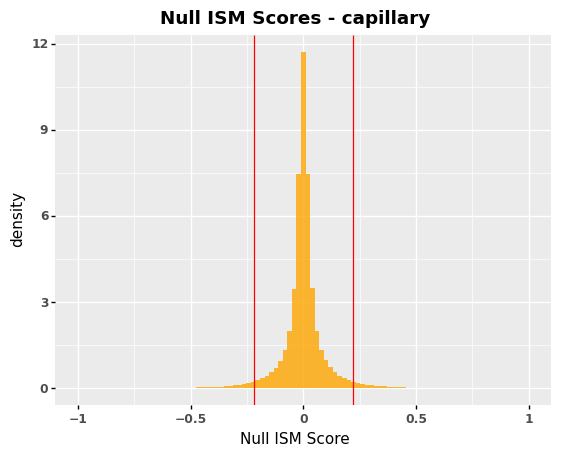

<ggplot: (8783321936110)>



cfwk6


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


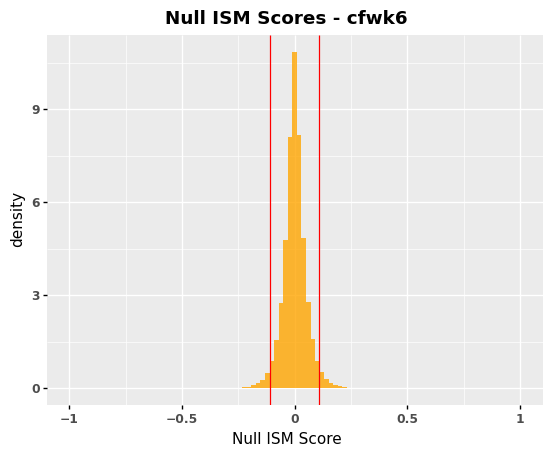

<ggplot: (8783321912450)>



endocardium


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 1357 rows containing non-finite values.
/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


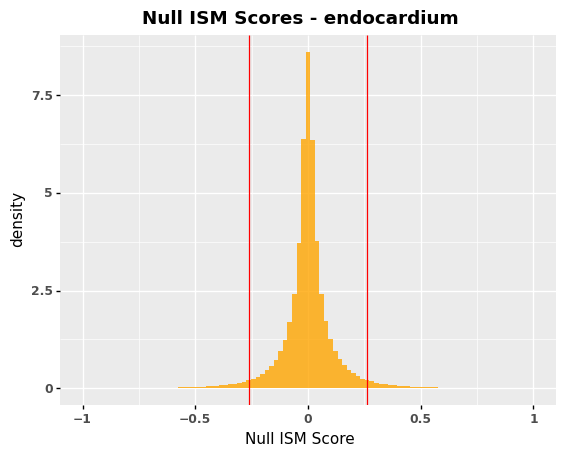

<ggplot: (8783321936062)>



lymphec


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


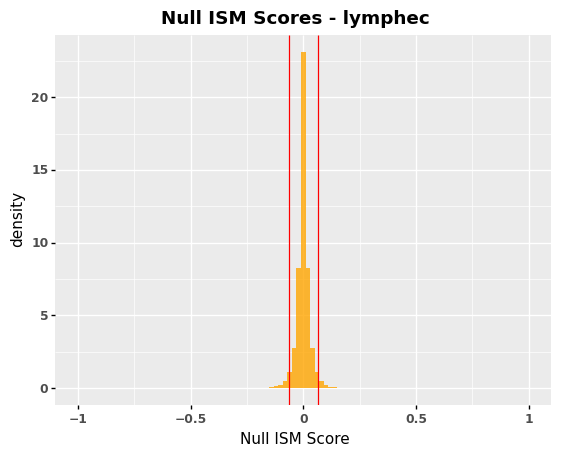

<ggplot: (8783321759748)>



neuralcrest


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


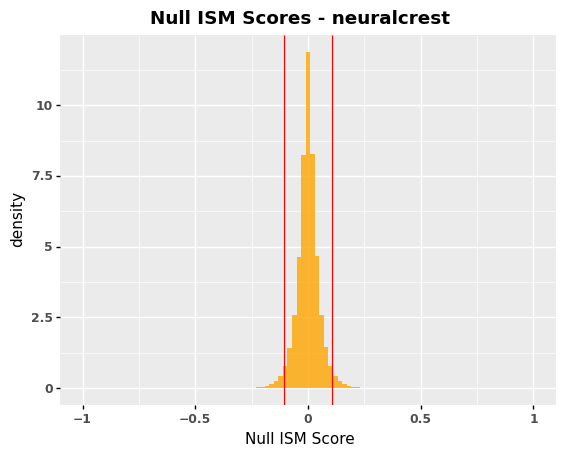

<ggplot: (8783321759844)>



pericytes


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


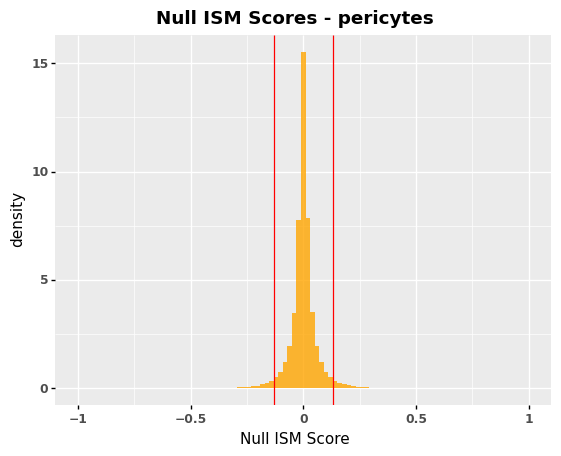

<ggplot: (8783321751197)>



smcwk6


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 2 rows containing non-finite values.
/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


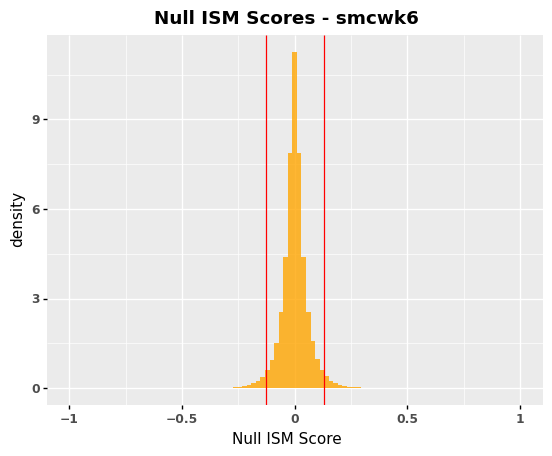

<ggplot: (8783321686559)>



valveearly


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 3 rows containing non-finite values.
/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


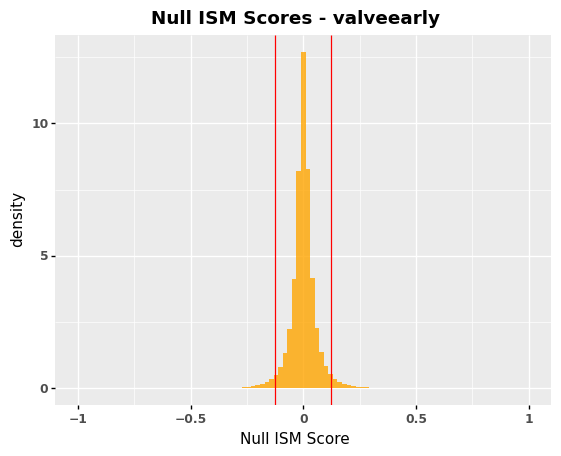

<ggplot: (8783321687209)>



veins


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 5 rows containing non-finite values.
/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


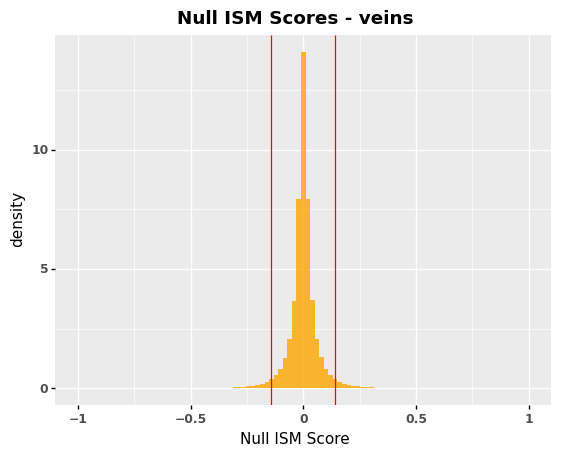

<ggplot: (8783321594670)>



all


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 27309 rows containing non-finite values.
/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


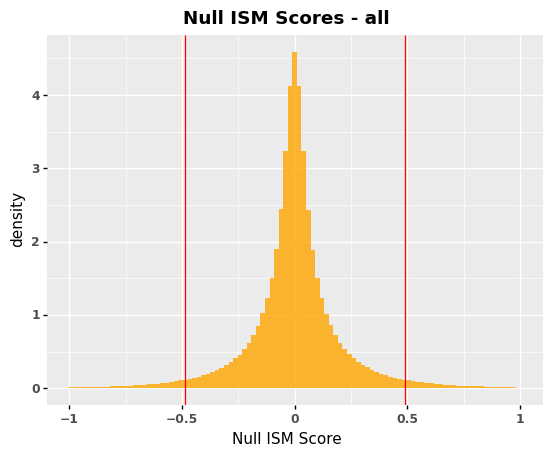

<ggplot: (8783321877637)>

In [5]:
null_ism_scores = {'atrial': [], 'cfmature': [], 'cfwk8': [], 'epiicardium': [],
                   'myocardium': [], 'smcwk19': [], 'smcwk8': [], 'valvelate': [], 'ventricular': [],
                   'arteries': [], 'capillary': [], 'cfwk6': [], 'endocardium': [], 'lymphec': [],
                   'neuralcrest': [], 'pericytes': [], 'smcwk6': [], 'valveearly': [], 'veins': [], 'all': []}

fold = 0

for cluster in null_ism_scores:
    print()
    print(cluster)
    shuf_counts0_chr4 = np.load(ism_indir + '/' + cluster + '/fold' + str(fold) + '/' + 'chr4' + '.shuf_counts.0.npy')
    shuf_counts0_chr7 = np.load(ism_indir + '/' + cluster + '/fold' + str(fold) + '/' + 'chr7' + '.shuf_counts.0.npy')
    shuf_counts0 = np.concatenate((shuf_counts0_chr4, shuf_counts0_chr7))
    
    shuf_counts1_chr4 = np.load(ism_indir + '/' + cluster + '/fold' + str(fold) + '/' + 'chr4' + '.shuf_counts.1.npy')
    shuf_counts1_chr7 = np.load(ism_indir + '/' + cluster + '/fold' + str(fold) + '/' + 'chr7' + '.shuf_counts.1.npy')
    shuf_counts1 = np.concatenate((shuf_counts1_chr4, shuf_counts1_chr7))
    
    shuf_counts2_chr4 = np.load(ism_indir + '/' + cluster + '/fold' + str(fold) + '/' + 'chr4' + '.shuf_counts.2.npy')
    shuf_counts2_chr7 = np.load(ism_indir + '/' + cluster + '/fold' + str(fold) + '/' + 'chr7' + '.shuf_counts.2.npy')
    shuf_counts2 = np.concatenate((shuf_counts2_chr4, shuf_counts2_chr7))
    
    logfc_counts_01 = np.log2(np.sum(shuf_counts0, axis=1) / np.sum(shuf_counts1, axis=1))
    logfc_counts_02 = np.log2(np.sum(shuf_counts0, axis=1) / np.sum(shuf_counts2, axis=1))
    logfc_counts_12 = np.log2(np.sum(shuf_counts1, axis=1) / np.sum(shuf_counts2, axis=1))
    
    logfc_counts = np.concatenate((logfc_counts_01, logfc_counts_02, logfc_counts_12))
    
    null_ism_scores[cluster] = logfc_counts
    
    null_df = pd.DataFrame(logfc_counts, columns=['null_score'])
    null_quantiles = list(null_df['null_score'].quantile([0.025, 0.975]))

    display(ggplot(data=null_df, mapping=aes(x='null_score'))       
            + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
            + labs(title='Null ISM Scores - ' + cluster, x='Null ISM Score')
            + geom_vline(mapping=aes(xintercept=null_quantiles[0]), color='red')
            + geom_vline(mapping=aes(xintercept=null_quantiles[1]), color='red')
            + xlim(-1,1))
    print()

## Get Active Motifs

In [6]:
active_motifs = {'atrial': [], 'cfmature': [], 'cfwk8': [], 'epiicardium': [],
                 'myocardium': [], 'smcwk19': [], 'smcwk8': [], 'valvelate': [], 'ventricular': [],
                 'arteries': [], 'capillary': [], 'cfwk6': [], 'endocardium': [], 'lymphec': [],
                 'neuralcrest': [], 'pericytes': [], 'smcwk6': [], 'valveearly': [], 'veins': [], 'all': []}

thresh_dict = {'atrial': [], 'cfmature': [], 'cfwk8': [], 'epiicardium': [],
               'myocardium': [], 'smcwk19': [], 'smcwk8': [], 'valvelate': [], 'ventricular': [],
               'arteries': [], 'capillary': [], 'cfwk6': [], 'endocardium': [], 'lymphec': [],
               'neuralcrest': [], 'pericytes': [], 'smcwk6': [], 'valveearly': [], 'veins': [], 'all': []}

active_thresh = 0.95

for cluster in active_motifs:
    print(cluster)
    active_motifs[cluster] = all_scores.loc[(all_scores[cluster + '_motif_logfc'] >= np.quantile(null_ism_scores[cluster], active_thresh)) |
                                            (all_scores[cluster + '_motif_logfc'] <= np.quantile(null_ism_scores[cluster], (1 - active_thresh)))].reset_index(drop=True).copy()

    thresh_dict[cluster].append(np.quantile(null_ism_scores[cluster], active_thresh))
    thresh_dict[cluster].append(np.quantile(null_ism_scores[cluster], (1 - active_thresh)))

    display(active_motifs[cluster].shape)
    print()

atrial


(3171604, 28)


cfmature


(3347846, 28)


cfwk8


(3489121, 28)


epiicardium


(3000341, 28)


myocardium


(3067094, 28)


smcwk19


(3538621, 28)


smcwk8


(3096178, 28)


valvelate


(3611452, 28)


ventricular


(3292253, 28)


arteries


(3477011, 28)


capillary


(3434536, 28)


cfwk6


(3005247, 28)


endocardium


(3382189, 28)


lymphec


(3467072, 28)


neuralcrest


(2688007, 28)


pericytes


(3337698, 28)


smcwk6


(2713203, 28)


valveearly


(2914065, 28)


veins


(3312829, 28)


all


(3591473, 28)

## Load Peaks

In [7]:
peak_dict = {'atrial': [], 'cfmature': [], 'cfwk8': [], 'epiicardium': [],
              'myocardium': [], 'smcwk19': [], 'smcwk8': [], 'valvelate': [], 'ventricular': [],
              'arteries': [], 'capillary': [], 'cfwk6': [], 'endocardium': [], 'lymphec': [],
              'neuralcrest': [], 'pericytes': [], 'smcwk6': [], 'valveearly': [], 'veins': [], 'all': []}

for cluster in peak_dict:
    peak_table = pd.read_csv(peak_dir + '/' + 'peaks_' + cluster + '_bpnet.csv', sep='\t', header=None)
    peak_table = peak_table[[0, 1, 2]]
    peak_table = peak_table.reset_index()
    peak_table.columns = ['peak_index', 'peak_chrom', 'peak_start', 'peak_end']
    peak_table = peak_table[['peak_chrom', 'peak_start', 'peak_end', 'peak_index']]
    peak_table['peak_name'] = peak_table['peak_chrom'] + '_' + peak_table['peak_start'].astype(str) + '_' + peak_table['peak_end'].astype(str)

    
    print()
    print(cluster)
    display(peak_table.head())
    display(peak_table.shape)
    
    peak_dict[cluster] = peak_table


atrial


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827039,828039,0,chr1_827039_828039
1,chr1,830971,831971,1,chr1_830971_831971
2,chr1,831821,832821,2,chr1_831821_832821
3,chr1,835198,836198,3,chr1_835198_836198
4,chr1,858348,859348,4,chr1_858348_859348


(65333, 5)


cfmature


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,826987,827987,0,chr1_826987_827987
1,chr1,904237,905237,1,chr1_904237_905237
2,chr1,904923,905923,2,chr1_904923_905923
3,chr1,920792,921792,3,chr1_920792_921792
4,chr1,923457,924457,4,chr1_923457_924457


(50224, 5)


cfwk8


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827014,828014,0,chr1_827014_828014
1,chr1,904240,905240,1,chr1_904240_905240
2,chr1,905072,906072,2,chr1_905072_906072
3,chr1,909624,910624,3,chr1_909624_910624
4,chr1,916175,917175,4,chr1_916175_917175


(68071, 5)


epiicardium


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827078,828078,0,chr1_827078_828078
1,chr1,869352,870352,1,chr1_869352_870352
2,chr1,904218,905218,2,chr1_904218_905218
3,chr1,909712,910712,3,chr1_909712_910712
4,chr1,910841,911841,4,chr1_910841_911841


(37155, 5)


myocardium


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827026,828026,0,chr1_827026_828026
1,chr1,865268,866268,1,chr1_865268_866268
2,chr1,865792,866792,2,chr1_865792_866792
3,chr1,904230,905230,3,chr1_904230_905230
4,chr1,920745,921745,4,chr1_920745_921745


(45079, 5)


smcwk19


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827003,828003,0,chr1_827003_828003
1,chr1,904217,905217,1,chr1_904217_905217
2,chr1,904968,905968,2,chr1_904968_905968
3,chr1,909670,910670,3,chr1_909670_910670
4,chr1,920714,921714,4,chr1_920714_921714


(35822, 5)


smcwk8


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,1000312,1001312,0,chr1_1000312_1001312
1,chr1,1001455,1002455,1,chr1_1001455_1002455
2,chr1,1019062,1020062,2,chr1_1019062_1020062
3,chr1,1019591,1020591,3,chr1_1019591_1020591
4,chr1,1032636,1033636,4,chr1_1032636_1033636


(14327, 5)


valvelate


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827037,828037,0,chr1_827037_828037
1,chr1,904252,905252,1,chr1_904252_905252
2,chr1,904933,905933,2,chr1_904933_905933
3,chr1,906533,907533,3,chr1_906533_907533
4,chr1,909704,910704,4,chr1_909704_910704


(46744, 5)


ventricular


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827057,828057,0,chr1_827057_828057
1,chr1,830927,831927,1,chr1_830927_831927
2,chr1,835180,836180,2,chr1_835180_836180
3,chr1,858372,859372,3,chr1_858372_859372
4,chr1,865300,866300,4,chr1_865300_866300


(89916, 5)


arteries


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827020,828020,0,chr1_827020_828020
1,chr1,869429,870429,1,chr1_869429_870429
2,chr1,904286,905286,2,chr1_904286_905286
3,chr1,920696,921696,3,chr1_920696_921696
4,chr1,925082,926082,4,chr1_925082_926082


(42664, 5)


capillary


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827040,828040,0,chr1_827040_828040
1,chr1,869380,870380,1,chr1_869380_870380
2,chr1,904280,905280,2,chr1_904280_905280
3,chr1,909971,910971,3,chr1_909971_910971
4,chr1,920735,921735,4,chr1_920735_921735


(55990, 5)


cfwk6


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,924334,925334,0,chr1_924334_925334
1,chr1,999659,1000659,1,chr1_999659_1000659
2,chr1,1000347,1001347,2,chr1_1000347_1001347
3,chr1,1004998,1005998,3,chr1_1004998_1005998
4,chr1,1020868,1021868,4,chr1_1020868_1021868


(20075, 5)


endocardium


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827042,828042,0,chr1_827042_828042
1,chr1,869406,870406,1,chr1_869406_870406
2,chr1,904236,905236,2,chr1_904236_905236
3,chr1,904888,905888,3,chr1_904888_905888
4,chr1,910823,911823,4,chr1_910823_911823


(79671, 5)


lymphec


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827030,828030,0,chr1_827030_828030
1,chr1,920736,921736,1,chr1_920736_921736
2,chr1,923459,924459,2,chr1_923459_924459
3,chr1,925179,926179,3,chr1_925179_926179
4,chr1,939810,940810,4,chr1_939810_940810


(26216, 5)


neuralcrest


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,826952,827952,0,chr1_826952_827952
1,chr1,904310,905310,1,chr1_904310_905310
2,chr1,920693,921693,2,chr1_920693_921693
3,chr1,923443,924443,3,chr1_923443_924443
4,chr1,924427,925427,4,chr1_924427_925427


(19210, 5)


pericytes


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,826715,827715,0,chr1_826715_827715
1,chr1,904192,905192,1,chr1_904192_905192
2,chr1,904899,905899,2,chr1_904899_905899
3,chr1,920724,921724,3,chr1_920724_921724
4,chr1,923434,924434,4,chr1_923434_924434


(32175, 5)


smcwk6


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,920710,921710,0,chr1_920710_921710
1,chr1,923375,924375,1,chr1_923375_924375
2,chr1,924131,925131,2,chr1_924131_925131
3,chr1,940014,941014,3,chr1_940014_941014
4,chr1,941307,942307,4,chr1_941307_942307


(19438, 5)


valveearly


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,909624,910624,0,chr1_909624_910624
1,chr1,920756,921756,1,chr1_920756_921756
2,chr1,923381,924381,2,chr1_923381_924381
3,chr1,939437,940437,3,chr1_939437_940437
4,chr1,939997,940997,4,chr1_939997_940997


(30246, 5)


veins


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827101,828101,0,chr1_827101_828101
1,chr1,869418,870418,1,chr1_869418_870418
2,chr1,920704,921704,2,chr1_920704_921704
3,chr1,924400,925400,3,chr1_924400_925400
4,chr1,939427,940427,4,chr1_939427_940427


(25292, 5)


all


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827078,828078,0,chr1_827078_828078
1,chr1,830971,831971,1,chr1_830971_831971
2,chr1,831821,832821,2,chr1_831821_832821
3,chr1,835198,836198,3,chr1_835198_836198
4,chr1,858420,859420,4,chr1_858420_859420


(239499, 5)

## Trim peaks to 500 bp

In [8]:
trimmed_peak_dict = {'atrial': [], 'cfmature': [], 'cfwk8': [], 'epiicardium': [],
                     'myocardium': [], 'smcwk19': [], 'smcwk8': [], 'valvelate': [], 'ventricular': [],
                     'arteries': [], 'capillary': [], 'cfwk6': [], 'endocardium': [], 'lymphec': [],
                     'neuralcrest': [], 'pericytes': [], 'smcwk6': [], 'valveearly': [], 'veins': [], 'all': []}

for cluster in peak_dict:
    trimmed_peak = peak_dict[cluster].copy()
    trimmed_peak['peak_start'] = trimmed_peak['peak_start'] + 250
    trimmed_peak['peak_end'] = trimmed_peak['peak_end'] - 250
    trimmed_peak['peak_name'] = trimmed_peak['peak_chrom'] + '_' + trimmed_peak['peak_start'].astype(str) + '_' + trimmed_peak['peak_end'].astype(str)

    print()
    print(cluster)
    display(trimmed_peak.head())
    display(trimmed_peak.shape)
    
    trimmed_peak_dict[cluster] = trimmed_peak


atrial


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827289,827789,0,chr1_827289_827789
1,chr1,831221,831721,1,chr1_831221_831721
2,chr1,832071,832571,2,chr1_832071_832571
3,chr1,835448,835948,3,chr1_835448_835948
4,chr1,858598,859098,4,chr1_858598_859098


(65333, 5)


cfmature


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827237,827737,0,chr1_827237_827737
1,chr1,904487,904987,1,chr1_904487_904987
2,chr1,905173,905673,2,chr1_905173_905673
3,chr1,921042,921542,3,chr1_921042_921542
4,chr1,923707,924207,4,chr1_923707_924207


(50224, 5)


cfwk8


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827264,827764,0,chr1_827264_827764
1,chr1,904490,904990,1,chr1_904490_904990
2,chr1,905322,905822,2,chr1_905322_905822
3,chr1,909874,910374,3,chr1_909874_910374
4,chr1,916425,916925,4,chr1_916425_916925


(68071, 5)


epiicardium


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827328,827828,0,chr1_827328_827828
1,chr1,869602,870102,1,chr1_869602_870102
2,chr1,904468,904968,2,chr1_904468_904968
3,chr1,909962,910462,3,chr1_909962_910462
4,chr1,911091,911591,4,chr1_911091_911591


(37155, 5)


myocardium


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827276,827776,0,chr1_827276_827776
1,chr1,865518,866018,1,chr1_865518_866018
2,chr1,866042,866542,2,chr1_866042_866542
3,chr1,904480,904980,3,chr1_904480_904980
4,chr1,920995,921495,4,chr1_920995_921495


(45079, 5)


smcwk19


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827253,827753,0,chr1_827253_827753
1,chr1,904467,904967,1,chr1_904467_904967
2,chr1,905218,905718,2,chr1_905218_905718
3,chr1,909920,910420,3,chr1_909920_910420
4,chr1,920964,921464,4,chr1_920964_921464


(35822, 5)


smcwk8


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,1000562,1001062,0,chr1_1000562_1001062
1,chr1,1001705,1002205,1,chr1_1001705_1002205
2,chr1,1019312,1019812,2,chr1_1019312_1019812
3,chr1,1019841,1020341,3,chr1_1019841_1020341
4,chr1,1032886,1033386,4,chr1_1032886_1033386


(14327, 5)


valvelate


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827287,827787,0,chr1_827287_827787
1,chr1,904502,905002,1,chr1_904502_905002
2,chr1,905183,905683,2,chr1_905183_905683
3,chr1,906783,907283,3,chr1_906783_907283
4,chr1,909954,910454,4,chr1_909954_910454


(46744, 5)


ventricular


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827307,827807,0,chr1_827307_827807
1,chr1,831177,831677,1,chr1_831177_831677
2,chr1,835430,835930,2,chr1_835430_835930
3,chr1,858622,859122,3,chr1_858622_859122
4,chr1,865550,866050,4,chr1_865550_866050


(89916, 5)


arteries


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827270,827770,0,chr1_827270_827770
1,chr1,869679,870179,1,chr1_869679_870179
2,chr1,904536,905036,2,chr1_904536_905036
3,chr1,920946,921446,3,chr1_920946_921446
4,chr1,925332,925832,4,chr1_925332_925832


(42664, 5)


capillary


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827290,827790,0,chr1_827290_827790
1,chr1,869630,870130,1,chr1_869630_870130
2,chr1,904530,905030,2,chr1_904530_905030
3,chr1,910221,910721,3,chr1_910221_910721
4,chr1,920985,921485,4,chr1_920985_921485


(55990, 5)


cfwk6


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,924584,925084,0,chr1_924584_925084
1,chr1,999909,1000409,1,chr1_999909_1000409
2,chr1,1000597,1001097,2,chr1_1000597_1001097
3,chr1,1005248,1005748,3,chr1_1005248_1005748
4,chr1,1021118,1021618,4,chr1_1021118_1021618


(20075, 5)


endocardium


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827292,827792,0,chr1_827292_827792
1,chr1,869656,870156,1,chr1_869656_870156
2,chr1,904486,904986,2,chr1_904486_904986
3,chr1,905138,905638,3,chr1_905138_905638
4,chr1,911073,911573,4,chr1_911073_911573


(79671, 5)


lymphec


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827280,827780,0,chr1_827280_827780
1,chr1,920986,921486,1,chr1_920986_921486
2,chr1,923709,924209,2,chr1_923709_924209
3,chr1,925429,925929,3,chr1_925429_925929
4,chr1,940060,940560,4,chr1_940060_940560


(26216, 5)


neuralcrest


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827202,827702,0,chr1_827202_827702
1,chr1,904560,905060,1,chr1_904560_905060
2,chr1,920943,921443,2,chr1_920943_921443
3,chr1,923693,924193,3,chr1_923693_924193
4,chr1,924677,925177,4,chr1_924677_925177


(19210, 5)


pericytes


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,826965,827465,0,chr1_826965_827465
1,chr1,904442,904942,1,chr1_904442_904942
2,chr1,905149,905649,2,chr1_905149_905649
3,chr1,920974,921474,3,chr1_920974_921474
4,chr1,923684,924184,4,chr1_923684_924184


(32175, 5)


smcwk6


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,920960,921460,0,chr1_920960_921460
1,chr1,923625,924125,1,chr1_923625_924125
2,chr1,924381,924881,2,chr1_924381_924881
3,chr1,940264,940764,3,chr1_940264_940764
4,chr1,941557,942057,4,chr1_941557_942057


(19438, 5)


valveearly


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,909874,910374,0,chr1_909874_910374
1,chr1,921006,921506,1,chr1_921006_921506
2,chr1,923631,924131,2,chr1_923631_924131
3,chr1,939687,940187,3,chr1_939687_940187
4,chr1,940247,940747,4,chr1_940247_940747


(30246, 5)


veins


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827351,827851,0,chr1_827351_827851
1,chr1,869668,870168,1,chr1_869668_870168
2,chr1,920954,921454,2,chr1_920954_921454
3,chr1,924650,925150,3,chr1_924650_925150
4,chr1,939677,940177,4,chr1_939677_940177


(25292, 5)


all


,peak_chrom,peak_start,peak_end,peak_index,peak_name
0,chr1,827328,827828,0,chr1_827328_827828
1,chr1,831221,831721,1,chr1_831221_831721
2,chr1,832071,832571,2,chr1_832071_832571
3,chr1,835448,835948,3,chr1_835448_835948
4,chr1,858670,859170,4,chr1_858670_859170


(239499, 5)

## Intersect Trimmed Peaks and Active Motifs

In [9]:
for cluster in active_motifs:
    
    print(cluster)
    
    peak_bed = pybedtools.BedTool.from_dataframe(trimmed_peak_dict[cluster])
    active_bed = pybedtools.BedTool.from_dataframe(active_motifs[cluster])
    intersect_bed = active_bed.intersect(peak_bed, u=True, wa=True)
    intersect_df = pybedtools.BedTool.to_dataframe(intersect_bed, header=None)
    intersect_df.columns = active_motifs[cluster].columns
    active_motifs[cluster] = intersect_df

atrial


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


cfmature


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


cfwk8


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


epiicardium


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


myocardium


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


smcwk19


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


smcwk8


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


valvelate


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


ventricular


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


arteries


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


capillary


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


cfwk6


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


endocardium


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


lymphec


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


neuralcrest


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


pericytes


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


smcwk6


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


valveearly


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


veins


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


all


/home/groups/akundaje/soumyak/miniconda3/lib/python3.8/site-packages/pybedtools/bedtool.py:3682: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 28 fields; you can supply custom names with the `names` kwarg


## Display Active Motifs

In [10]:
for cluster in active_motifs:
    print(cluster)
    display(active_motifs[cluster].head(5))
    print()
    display(active_motifs[cluster].shape)

atrial


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827330,827349,TP53_706,706,20,-,0.558635,0.175540,0.050794,...,0.271743,0.073436,0.166649,0.025630,0.004884,0.062407,0.063134,0.070964,0.030418,0.074180
1,chr1,827332,827342,ELK4_341,341,11,-,9.099155,0.118709,0.106342,...,0.289297,0.074657,0.112512,0.051665,-0.003879,0.079872,0.042494,0.098870,0.066708,0.239036
2,chr1,827333,827342,ETS1_332,332,10,-,8.216554,0.121135,0.082777,...,0.285599,0.072843,0.100030,0.058699,0.001098,0.081662,0.041229,0.078143,0.061024,0.254197
3,chr1,827333,827343,GABPA_338,338,11,-,8.423750,0.172376,0.116309,...,0.335445,0.083054,0.160597,0.063036,0.016597,0.093625,0.051085,0.105485,0.051499,0.179919
4,chr1,827337,827354,AHRR_17,17,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867


(1361920, 28)

cfmature


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827332,827342,ELK4_341,341,11,-,9.099155,0.118709,0.106342,...,0.289297,0.074657,0.112512,0.051665,-0.003879,0.079872,0.042494,0.098870,0.066708,0.239036
1,chr1,827333,827343,GABPA_338,338,11,-,8.423750,0.172376,0.116309,...,0.335445,0.083054,0.160597,0.063036,0.016597,0.093625,0.051085,0.105485,0.051499,0.179919
2,chr1,827337,827354,AHRR_17,17,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867
3,chr1,827337,827354,AHR_28,28,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867
4,chr1,827366,827382,PURA_813,813,17,-,8.699766,0.081422,0.127604,...,0.232738,0.055194,0.143886,0.065273,0.062870,0.064218,0.020284,0.058709,0.096635,0.375105


(1133757, 28)

cfwk8


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827330,827349,TP53_706,706,20,-,0.558635,0.175540,0.050794,...,0.271743,0.073436,0.166649,0.025630,0.004884,0.062407,0.063134,0.070964,0.030418,0.074180
1,chr1,827332,827342,ELK4_341,341,11,-,9.099155,0.118709,0.106342,...,0.289297,0.074657,0.112512,0.051665,-0.003879,0.079872,0.042494,0.098870,0.066708,0.239036
2,chr1,827333,827342,ETS1_332,332,10,-,8.216554,0.121135,0.082777,...,0.285599,0.072843,0.100030,0.058699,0.001098,0.081662,0.041229,0.078143,0.061024,0.254197
3,chr1,827333,827343,GABPA_338,338,11,-,8.423750,0.172376,0.116309,...,0.335445,0.083054,0.160597,0.063036,0.016597,0.093625,0.051085,0.105485,0.051499,0.179919
4,chr1,827337,827354,AHRR_17,17,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867


(1284814, 28)

epiicardium


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827330,827349,TP53_706,706,20,-,0.558635,0.175540,0.050794,...,0.271743,0.073436,0.166649,0.025630,0.004884,0.062407,0.063134,0.070964,0.030418,0.074180
1,chr1,827332,827342,ELK4_341,341,11,-,9.099155,0.118709,0.106342,...,0.289297,0.074657,0.112512,0.051665,-0.003879,0.079872,0.042494,0.098870,0.066708,0.239036
2,chr1,827333,827342,ETS1_332,332,10,-,8.216554,0.121135,0.082777,...,0.285599,0.072843,0.100030,0.058699,0.001098,0.081662,0.041229,0.078143,0.061024,0.254197
3,chr1,827333,827343,GABPA_338,338,11,-,8.423750,0.172376,0.116309,...,0.335445,0.083054,0.160597,0.063036,0.016597,0.093625,0.051085,0.105485,0.051499,0.179919
4,chr1,827337,827354,AHRR_17,17,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867


(771191, 28)

myocardium


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827332,827342,ELK4_341,341,11,-,9.099155,0.118709,0.106342,...,0.289297,0.074657,0.112512,0.051665,-0.003879,0.079872,0.042494,0.098870,0.066708,0.239036
1,chr1,827333,827342,ETS1_332,332,10,-,8.216554,0.121135,0.082777,...,0.285599,0.072843,0.100030,0.058699,0.001098,0.081662,0.041229,0.078143,0.061024,0.254197
2,chr1,827366,827382,PURA_813,813,17,-,8.699766,0.081422,0.127604,...,0.232738,0.055194,0.143886,0.065273,0.062870,0.064218,0.020284,0.058709,0.096635,0.375105
3,chr1,827536,827550,ZBTB7A_258,258,15,+,10.076939,0.152581,0.198918,...,0.190534,0.198318,0.098478,0.125986,0.097517,0.154469,0.139104,0.132838,0.237752,0.335344
4,chr1,827539,827552,KLF14_251,251,14,+,7.692037,0.100974,0.212070,...,0.199848,0.173111,0.109442,0.124812,0.101961,0.151352,0.178548,0.099922,0.202929,0.330490


(813269, 28)

smcwk19


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827330,827349,TP53_706,706,20,-,0.558635,0.175540,0.050794,...,0.271743,0.073436,0.166649,0.025630,0.004884,0.062407,0.063134,0.070964,0.030418,0.074180
1,chr1,827332,827342,ELK4_341,341,11,-,9.099155,0.118709,0.106342,...,0.289297,0.074657,0.112512,0.051665,-0.003879,0.079872,0.042494,0.098870,0.066708,0.239036
2,chr1,827333,827342,ETS1_332,332,10,-,8.216554,0.121135,0.082777,...,0.285599,0.072843,0.100030,0.058699,0.001098,0.081662,0.041229,0.078143,0.061024,0.254197
3,chr1,827333,827343,GABPA_338,338,11,-,8.423750,0.172376,0.116309,...,0.335445,0.083054,0.160597,0.063036,0.016597,0.093625,0.051085,0.105485,0.051499,0.179919
4,chr1,827337,827354,AHRR_17,17,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867


(1139339, 28)

smcwk8


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,1000746,1000756,E2F6_317,317,11,+,9.513452,0.067283,0.054627,...,0.175482,0.051523,0.048713,0.040578,0.059154,0.089809,0.029446,-0.013485,0.060931,0.035508
1,chr1,1000748,1000762,ZNF148_222,222,15,+,9.585808,0.089818,0.058128,...,0.225246,0.075346,0.078113,0.079238,0.063570,0.132253,0.043059,0.007819,0.096471,0.045126
2,chr1,1000748,1000762,E2F4_318,318,15,+,9.550516,0.089818,0.058128,...,0.225246,0.075346,0.078113,0.079238,0.063570,0.132253,0.043059,0.007819,0.096471,0.045126
3,chr1,1000749,1000763,SP2_232,232,15,+,8.447492,0.101844,0.093516,...,0.257129,0.107901,0.100414,0.084374,0.095476,0.172379,0.078935,0.030054,0.117871,0.073583
4,chr1,1000752,1000768,MAZ_178,178,17,+,7.925012,0.065277,0.046131,...,0.215873,0.068122,0.073274,0.066103,0.082225,0.143364,0.032678,0.007663,0.083345,0.045517


(499723, 28)

valvelate


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827330,827349,TP53_706,706,20,-,0.558635,0.175540,0.050794,...,0.271743,0.073436,0.166649,0.025630,0.004884,0.062407,0.063134,0.070964,0.030418,0.074180
1,chr1,827332,827342,ELK4_341,341,11,-,9.099155,0.118709,0.106342,...,0.289297,0.074657,0.112512,0.051665,-0.003879,0.079872,0.042494,0.098870,0.066708,0.239036
2,chr1,827333,827342,ETS1_332,332,10,-,8.216554,0.121135,0.082777,...,0.285599,0.072843,0.100030,0.058699,0.001098,0.081662,0.041229,0.078143,0.061024,0.254197
3,chr1,827333,827343,GABPA_338,338,11,-,8.423750,0.172376,0.116309,...,0.335445,0.083054,0.160597,0.063036,0.016597,0.093625,0.051085,0.105485,0.051499,0.179919
4,chr1,827337,827354,AHRR_17,17,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867


(1263246, 28)

ventricular


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827479,827492,PAX8_707,707,14,+,7.257967,0.082234,0.108551,...,0.048774,0.103723,0.058853,0.034144,0.032433,0.101186,0.043536,0.031017,0.027625,0.034120
1,chr1,827505,827512,OTX1_437,437,8,+,7.909710,0.096842,0.121981,...,0.195386,0.094207,0.123639,0.094745,0.085806,0.152346,0.061419,0.135992,0.084160,0.060167
2,chr1,827509,827523,NR2C2_693,693,15,+,12.475248,0.061102,0.251471,...,0.319368,0.127858,0.238664,0.111443,0.089135,0.180198,0.066312,0.131637,0.215416,0.294953
3,chr1,827510,827520,ELK4_341,341,11,-,8.936444,0.031688,0.230463,...,0.279633,0.112485,0.210241,0.095880,0.101268,0.114996,0.071397,0.084877,0.177149,0.186277
4,chr1,827510,827523,ELF1_329,329,14,-,8.631622,0.054553,0.279591,...,0.354344,0.132366,0.219460,0.108086,0.101305,0.186537,0.063252,0.139803,0.208473,0.276075


(1745585, 28)

arteries


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827330,827349,TP53_706,706,20,-,0.558635,0.175540,0.050794,...,0.271743,0.073436,0.166649,0.025630,0.004884,0.062407,0.063134,0.070964,0.030418,0.074180
1,chr1,827333,827343,GABPA_338,338,11,-,8.423750,0.172376,0.116309,...,0.335445,0.083054,0.160597,0.063036,0.016597,0.093625,0.051085,0.105485,0.051499,0.179919
2,chr1,827337,827354,AHRR_17,17,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867
3,chr1,827337,827354,AHR_28,28,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867
4,chr1,827366,827382,PURA_813,813,17,-,8.699766,0.081422,0.127604,...,0.232738,0.055194,0.143886,0.065273,0.062870,0.064218,0.020284,0.058709,0.096635,0.375105


(1138408, 28)

capillary


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827330,827349,TP53_706,706,20,-,0.558635,0.175540,0.050794,...,0.271743,0.073436,0.166649,0.025630,0.004884,0.062407,0.063134,0.070964,0.030418,0.074180
1,chr1,827332,827342,ELK4_341,341,11,-,9.099155,0.118709,0.106342,...,0.289297,0.074657,0.112512,0.051665,-0.003879,0.079872,0.042494,0.098870,0.066708,0.239036
2,chr1,827333,827342,ETS1_332,332,10,-,8.216554,0.121135,0.082777,...,0.285599,0.072843,0.100030,0.058699,0.001098,0.081662,0.041229,0.078143,0.061024,0.254197
3,chr1,827333,827343,GABPA_338,338,11,-,8.423750,0.172376,0.116309,...,0.335445,0.083054,0.160597,0.063036,0.016597,0.093625,0.051085,0.105485,0.051499,0.179919
4,chr1,827337,827354,AHRR_17,17,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867


(1330967, 28)

cfwk6


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,924909,924919,SMAD2_745,745,11,-,8.215955,-0.018532,0.027514,...,0.037819,0.060596,-0.005843,-0.010632,0.033496,0.039433,0.037724,0.055424,0.101090,0.037634
1,chr1,924957,924967,SP1_267,267,11,-,8.155608,0.056188,0.114332,...,0.088156,0.061567,0.054487,0.044324,0.027097,0.109107,0.085705,0.084572,0.100465,0.133226
2,chr1,924990,925006,KLF15_223,223,17,-,8.394541,-0.123986,-0.088543,...,-0.181865,-0.061210,-0.085516,-0.073371,-0.061622,-0.069987,-0.078194,-0.043831,-0.028788,-0.127621
3,chr1,1000081,1000099,ZFX_158,158,19,+,8.716920,0.038165,0.091257,...,0.005410,0.093230,0.020774,-0.003913,-0.032087,0.057277,-0.000970,0.076722,-0.007401,0.153016
4,chr1,1000164,1000175,ZNF75A_219,219,12,-,8.917098,0.136071,0.082885,...,0.133485,0.074889,0.206057,0.023312,0.047944,0.057983,0.007260,0.132403,0.004824,0.248310


(449087, 28)

endocardium


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827330,827349,TP53_706,706,20,-,0.558635,0.175540,0.050794,...,0.271743,0.073436,0.166649,0.025630,0.004884,0.062407,0.063134,0.070964,0.030418,0.074180
1,chr1,827333,827343,GABPA_338,338,11,-,8.423750,0.172376,0.116309,...,0.335445,0.083054,0.160597,0.063036,0.016597,0.093625,0.051085,0.105485,0.051499,0.179919
2,chr1,827337,827354,AHRR_17,17,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867
3,chr1,827337,827354,AHR_28,28,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867
4,chr1,827366,827382,PURA_813,813,17,-,8.699766,0.081422,0.127604,...,0.232738,0.055194,0.143886,0.065273,0.062870,0.064218,0.020284,0.058709,0.096635,0.375105


(1562625, 28)

lymphec


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827332,827342,ELK4_341,341,11,-,9.099155,0.118709,0.106342,...,0.289297,0.074657,0.112512,0.051665,-0.003879,0.079872,0.042494,0.098870,0.066708,0.239036
1,chr1,827333,827342,ETS1_332,332,10,-,8.216554,0.121135,0.082777,...,0.285599,0.072843,0.100030,0.058699,0.001098,0.081662,0.041229,0.078143,0.061024,0.254197
2,chr1,827333,827343,GABPA_338,338,11,-,8.423750,0.172376,0.116309,...,0.335445,0.083054,0.160597,0.063036,0.016597,0.093625,0.051085,0.105485,0.051499,0.179919
3,chr1,827337,827354,AHRR_17,17,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867
4,chr1,827337,827354,AHR_28,28,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867


(879046, 28)

neuralcrest


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827337,827354,AHRR_17,17,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867
1,chr1,827337,827354,AHR_28,28,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867
2,chr1,827366,827382,PURA_813,813,17,-,8.699766,0.081422,0.127604,...,0.232738,0.055194,0.143886,0.065273,0.062870,0.064218,0.020284,0.058709,0.096635,0.375105
3,chr1,827473,827486,NR1H4_655,655,14,+,8.243691,-0.044194,-0.181504,...,-0.168109,-0.056660,-0.081671,-0.070900,-0.077592,-0.140401,-0.086728,-0.100117,-0.097570,-0.148611
4,chr1,827503,827511,RHOXF1_409,409,9,+,8.909353,0.067509,0.158862,...,0.111591,0.048186,0.111115,0.065709,0.074750,0.102055,0.001682,0.094620,0.061638,-0.211898


(435426, 28)

pericytes


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827330,827349,TP53_706,706,20,-,0.558635,0.175540,0.050794,...,0.271743,0.073436,0.166649,0.025630,0.004884,0.062407,0.063134,0.070964,0.030418,0.074180
1,chr1,827332,827342,ELK4_341,341,11,-,9.099155,0.118709,0.106342,...,0.289297,0.074657,0.112512,0.051665,-0.003879,0.079872,0.042494,0.098870,0.066708,0.239036
2,chr1,827333,827342,ETS1_332,332,10,-,8.216554,0.121135,0.082777,...,0.285599,0.072843,0.100030,0.058699,0.001098,0.081662,0.041229,0.078143,0.061024,0.254197
3,chr1,827333,827343,GABPA_338,338,11,-,8.423750,0.172376,0.116309,...,0.335445,0.083054,0.160597,0.063036,0.016597,0.093625,0.051085,0.105485,0.051499,0.179919
4,chr1,827337,827354,AHRR_17,17,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867


(905081, 28)

smcwk6


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,921106,921129,ZNF350_817,817,24,+,9.893761,-0.018736,-0.054165,...,0.013170,-0.051365,-0.139728,-0.018785,-0.052315,-0.153932,-0.072706,-0.003381,-0.052116,-0.180249
1,chr1,921148,921155,AL8445277_699,699,8,-,8.481510,-0.250206,-0.128418,...,-0.087721,-0.102259,-0.254941,-0.043113,-0.021685,-0.138161,-0.163497,-0.093637,-0.085180,-0.127040
2,chr1,921148,921155,AL6628245_700,700,8,-,8.481510,-0.250206,-0.128418,...,-0.087721,-0.102259,-0.254941,-0.043113,-0.021685,-0.138161,-0.163497,-0.093637,-0.085180,-0.127040
3,chr1,921148,921155,CR7597334_701,701,8,-,8.481510,-0.250206,-0.128418,...,-0.087721,-0.102259,-0.254941,-0.043113,-0.021685,-0.138161,-0.163497,-0.093637,-0.085180,-0.127040
4,chr1,921148,921155,CR3545653_702,702,8,-,8.481510,-0.250206,-0.128418,...,-0.087721,-0.102259,-0.254941,-0.043113,-0.021685,-0.138161,-0.163497,-0.093637,-0.085180,-0.127040


(467204, 28)

valveearly


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,909962,909976,ZBTB7A_258,258,15,+,10.041330,-0.120655,-0.145208,...,-0.094911,-0.055467,-0.129677,-0.036473,-0.033275,-0.089677,-0.063526,-0.113777,-0.138912,-0.103996
1,chr1,910020,910029,NHLH1_74,74,10,+,11.613404,0.100456,0.115406,...,0.048314,0.098792,0.051650,0.079823,0.038029,0.082544,0.086620,0.080158,0.070067,0.108604
2,chr1,910020,910029,NHLH1_74,74,10,-,11.613404,0.100456,0.115406,...,0.048314,0.098792,0.051650,0.079823,0.038029,0.082544,0.086620,0.080158,0.070067,0.108604
3,chr1,910020,910029,NHLH2_80,80,10,+,8.678962,0.100456,0.115406,...,0.048314,0.098792,0.051650,0.079823,0.038029,0.082544,0.086620,0.080158,0.070067,0.108604
4,chr1,910020,910029,NHLH2_80,80,10,-,8.678962,0.100456,0.115406,...,0.048314,0.098792,0.051650,0.079823,0.038029,0.082544,0.086620,0.080158,0.070067,0.108604


(672085, 28)

veins


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827337,827354,AHRR_17,17,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867
1,chr1,827337,827354,AHR_28,28,18,-,6.501711,0.175042,0.130953,...,0.326220,0.101094,0.264371,0.106080,0.058068,0.161813,0.076736,0.169433,0.078283,0.127867
2,chr1,827366,827382,PURA_813,813,17,-,8.699766,0.081422,0.127604,...,0.232738,0.055194,0.143886,0.065273,0.062870,0.064218,0.020284,0.058709,0.096635,0.375105
3,chr1,827371,827384,HIVEP2_160,160,14,-,8.791314,0.057339,0.117022,...,0.169698,0.066434,0.076648,0.068853,0.045361,0.058525,0.041099,0.058008,0.107175,0.230189
4,chr1,827412,827420,KLF8_174,174,9,+,9.200046,-0.031694,-0.119242,...,-0.119785,-0.029481,-0.050380,-0.028482,-0.050280,-0.118123,-0.060706,-0.028818,-0.077455,-0.182759


(652900, 28)

all


,chr,start,end,tf_name,tf_group,width,strand,score,atrial_motif_logfc,cfmature_motif_logfc,...,capillary_motif_logfc,cfwk6_motif_logfc,endocardium_motif_logfc,lymphec_motif_logfc,neuralcrest_motif_logfc,pericytes_motif_logfc,smcwk6_motif_logfc,valveearly_motif_logfc,veins_motif_logfc,all_motif_logfc
0,chr1,827332,827342,ELK4_341,341,11,-,9.099155,0.118709,0.106342,...,0.289297,0.074657,0.112512,0.051665,-0.003879,0.079872,0.042494,0.098870,0.066708,0.239036
1,chr1,827333,827342,ETS1_332,332,10,-,8.216554,0.121135,0.082777,...,0.285599,0.072843,0.100030,0.058699,0.001098,0.081662,0.041229,0.078143,0.061024,0.254197
2,chr1,827366,827382,PURA_813,813,17,-,8.699766,0.081422,0.127604,...,0.232738,0.055194,0.143886,0.065273,0.062870,0.064218,0.020284,0.058709,0.096635,0.375105
3,chr1,827371,827384,HIVEP2_160,160,14,-,8.791314,0.057339,0.117022,...,0.169698,0.066434,0.076648,0.068853,0.045361,0.058525,0.041099,0.058008,0.107175,0.230189
4,chr1,827503,827511,RHOXF1_409,409,9,+,8.909353,0.067509,0.158862,...,0.111591,0.048186,0.111115,0.065709,0.074750,0.102055,0.001682,0.094620,0.061638,-0.211898


(3090602, 28)

## Save Active Motifs

In [11]:
# Save Tables

print('Save Tables')
print()

for cluster in active_motifs:
    print(cluster)
    
    active_motifs[cluster].to_csv(ism_outdir + '/' + cluster + '.active_motifs.tsv', index=False, sep='\t')
    active_bed = active_motifs[cluster][['chr', 'start', 'end', 'tf_name', 'score', 'strand']]    
    active_bed.to_csv(ism_outdir + '/' + cluster + '.active_motifs.bed', index=False, sep='\t', header=False)

Save Tables

atrial
cfmature
cfwk8
epiicardium
myocardium
smcwk19
smcwk8
valvelate
ventricular
arteries
capillary
cfwk6
endocardium
lymphec
neuralcrest
pericytes
smcwk6
valveearly
veins
all
